# Bayesian Sharpe Ratio and Performance Comparison

This notebook illustrates how to define the Sharpe ratio as a probability model and compare the resulting posterior distributions for different return series. The Bayesian estimation for two groups provides complete distributions of credible values for the effect size, group means and their difference, standard deviations and their difference, and the normality of the data. 

Key use cases include the analysis of differences between alternative strategies, or between a strategy’s in-sample return relative to its out-of-sample return (see the notebook bayesian_sharpe_ratio for details). The Bayesian Sharpe ratio is also part of pyfolio’s Bayesian tearsheet.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import pymc3 as pm
import arviz
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [3]:
benchmark = web.DataReader('SP500', data_source='fred', start=2010)
benchmark.columns = ['benchmark']

In [4]:
with pd.HDFStore('../data/assets.h5') as store:
    stock = store['quandl/wiki/prices'].adj_close.unstack()['AMZN'].to_frame('stock')

In [5]:
data = stock.join(benchmark).pct_change().dropna().loc['2010':]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1790 entries, 2011-04-01 to 2018-03-27
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   stock      1790 non-null   float64
 1   benchmark  1790 non-null   float64
dtypes: float64(2)
memory usage: 42.0 KB


## Modeling the Sharpe Ratio

To model the Sharpe ratio as a probabilistic model, we need to priors about the distribution of returns and the parameters that govern this distribution. The student t distribution exhibits fat tails relative to the normal distribution for low degrees of freedom (df) and is a reasonable choice to capture this aspect of returns. 

### Define Probability Model

Hence, we need to model the three parameters of this distribution, namely the mean and standard deviation of returns, and the degrees of freedom. We’ll assume normal and uniform distributions for the mean and the standard deviation, respectively, and an exponential distribution for the df with a sufficiently low expected value to ensure fat tails. Returns are based on these probabilistic inputs, and the annualized Sharpe ratio results from the standard computation, ignoring a risk-free rate (using daily returns).

In [7]:
mean_prior = data.stock.mean()
std_prior = data.stock.std()
std_low = std_prior / 1000
std_high = std_prior * 1000

with pm.Model() as sharpe_model:
    mean = pm.Normal('mean', mu=mean_prior, sd=std_prior)
    std = pm.Uniform('std', lower=std_low, upper=std_high)

    nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
    returns = pm.StudentT('returns', nu=nu, mu=mean, sd=std, observed=data.stock)

    sharpe = returns.distribution.mean / returns.distribution.variance ** .5 * np.sqrt(252)
    pm.Deterministic('sharpe', sharpe)

In [8]:
sharpe_model.model

### Visualize Model

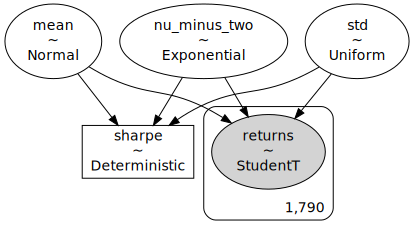

In [9]:
pm.model_to_graphviz(model=sharpe_model)

In [10]:
# optionally: persist graph
# graph = pm.model_to_graphviz(model=sharpe_model)
# graph.save('sharpe.dot')

### Approximate Inference: Hamiltonian Monte Carlo with the No U-Turn Sampler

In [11]:
tune = 2000
draws = 200
with sharpe_model:
    trace = pm.sample(tune=tune, 
                      draws=draws, 
                      chains=4, 
                      cores=1)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [nu_minus_two, std, mean]


Sampling 4 chains for 2_000 tune and 200 draw iterations (8_000 + 800 draws total) took 13 seconds.


### Inspect Trace

In [12]:
trace_df = pm.trace_to_dataframe(trace).assign(chain=lambda x: x.index // draws)
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean          800 non-null    float64
 1   std           800 non-null    float64
 2   nu_minus_two  800 non-null    float64
 3   sharpe        800 non-null    float64
 4   chain         800 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 31.4 KB


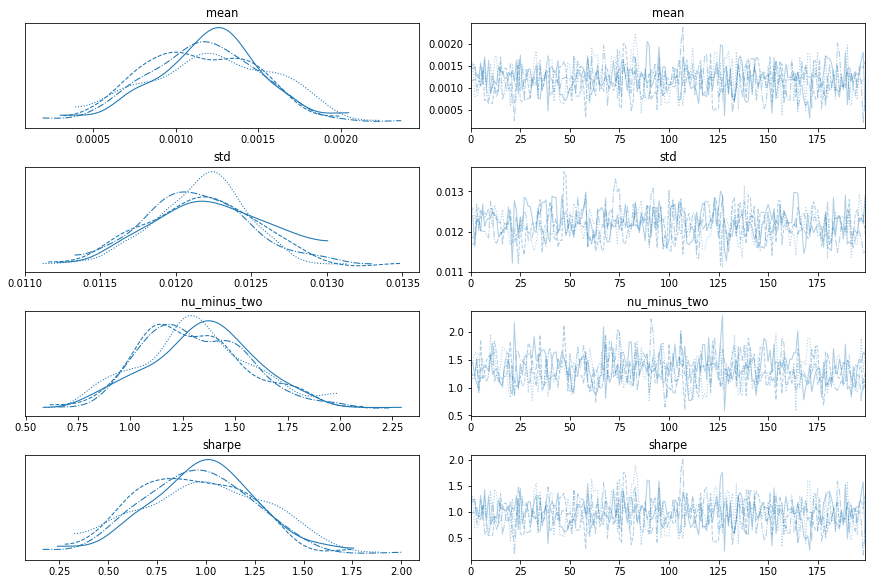

In [13]:
arviz.plot_trace(data=trace);

### Continue Sampling

In [14]:
draws = 25000
with sharpe_model:
    trace = pm.sample(draws=draws, 
                      trace=trace, 
                      chains=4, 
                      cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [nu_minus_two, std, mean]


Sampling 4 chains for 1_000 tune and 25_200 draw iterations (4_000 + 100_800 draws total) took 100 seconds.


In [15]:
pm.trace_to_dataframe(trace).shape

(100800, 4)

In [16]:
df = pm.trace_to_dataframe(trace).iloc[400:].reset_index(drop=True).assign(chain=lambda x: x.index // draws)
trace_df = pd.concat([trace_df.assign(run=1),
                      df.assign(run=2)])
trace_df.info()        

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101200 entries, 0 to 100399
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   mean          101200 non-null  float64
 1   std           101200 non-null  float64
 2   nu_minus_two  101200 non-null  float64
 3   sharpe        101200 non-null  float64
 4   chain         101200 non-null  int64  
 5   run           101200 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 5.4 MB


In [17]:
trace_df_long = pd.melt(trace_df, id_vars=['run', 'chain'])
trace_df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404800 entries, 0 to 404799
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   run       404800 non-null  int64  
 1   chain     404800 non-null  int64  
 2   variable  404800 non-null  object 
 3   value     404800 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 12.4+ MB


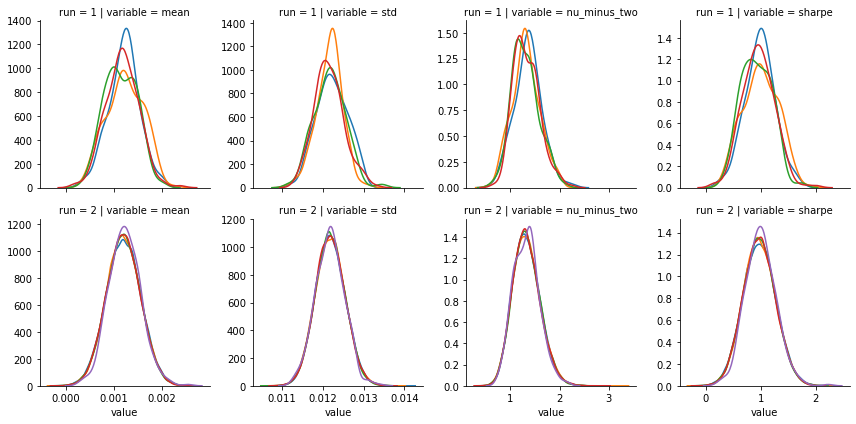

In [18]:
g = sns.FacetGrid(trace_df_long, col='variable', row='run', hue='chain', sharex='col', sharey=False)
g = g.map(sns.distplot, 'value', hist=False, rug=False)

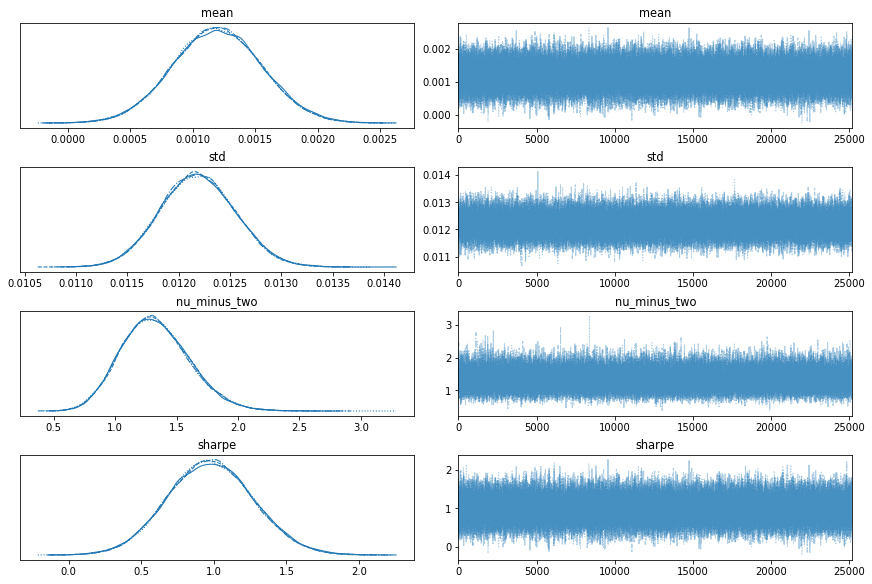

In [19]:
arviz.plot_trace(data=trace);

array([<AxesSubplot:title={'center':'mean'}>,
       <AxesSubplot:title={'center':'std'}>,
       <AxesSubplot:title={'center':'nu_minus_two'}>,
       <AxesSubplot:title={'center':'sharpe'}>], dtype=object)

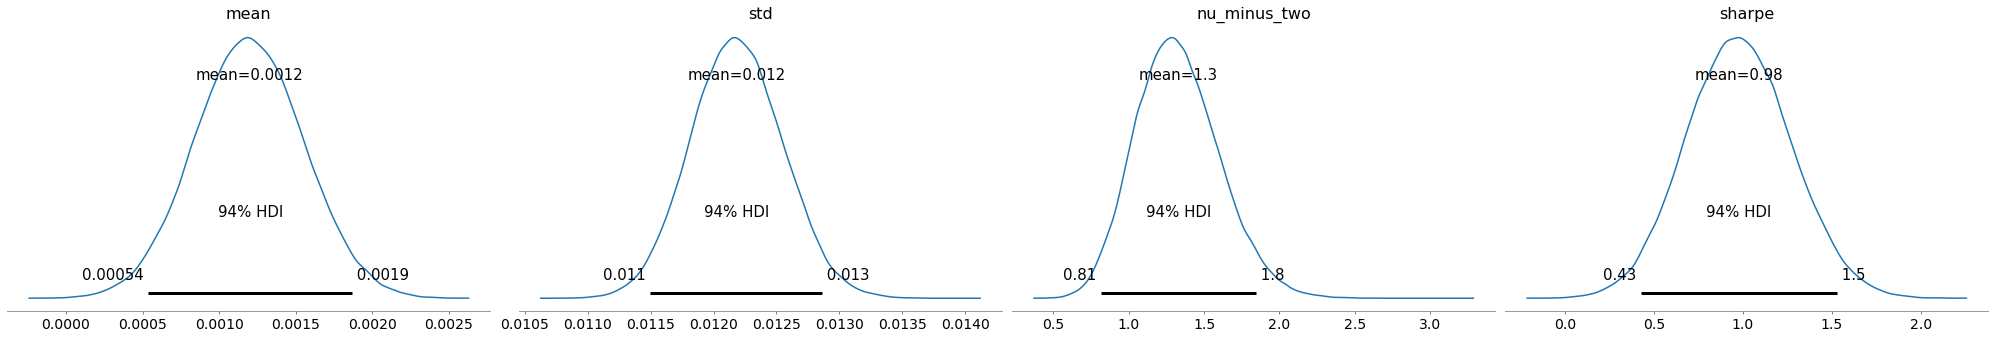

In [20]:
arviz.plot_posterior(data=trace)

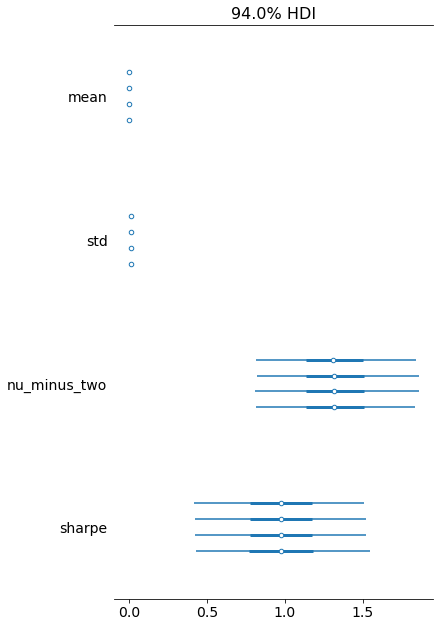

In [21]:
arviz.plot_forest(data=trace);

## Comparing Group Means: Bayesian Estimation Supersedes the T-Test (BEST)

This model runs a Bayesian hypothesis test to compare two return distributions. The returns could be for two different assets, or the in-sampls and out-of-sample returns for a target strategy. Returns are assumed to be T-distributed.

In addition, it computes the annualize volatility and Sharpe ratios for both return series.

The model is based on [Bayesian estimation supersedes the t-test](http://www.indiana.edu/~kruschke/BEST/BEST.pdf), John Kruschke, Journal of Experimental Psychology, 2012.

It is included in pyfolio's Bayesian tearsheet.

### The Data

In [22]:
data.describe()

,stock,benchmark
count,1790.000000,1790.000000
mean,0.001369,0.000420
std,0.019319,0.009025
min,-0.126568,-0.066634
25%,-0.007820,-0.003162
50%,0.000744,0.000347
75%,0.011188,0.004804
max,0.157457,0.047407


### Sharpe Ratio Comparison as a Probabilistic Model

In [23]:
group = {1: data.stock, 2: data.benchmark}
combined = pd.concat([g for i, g in group.items()])

# priors
mean_prior = combined.mean()
std_prior = combined.std()
std_low = std_prior / 1000
std_high = std_prior * 1000
T = 251 ** .5
mean, std, returns = {}, {}, {}
with pm.Model() as best:
    nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
    for i in [1, 2]:
        mean[i] = pm.Normal(f'mean_g{i}', mu=mean_prior, sd=std_prior, testval=group[i].mean())
        std[i] = pm.Uniform(f'std_g{i}', lower=std_low, upper=std_high, testval=group[i].std())
        returns[i] = pm.StudentT(f'returns_g{i}', nu=nu, mu=mean[i], sd=std[i], observed=group[i])
        pm.Deterministic(f'vol_g{i}', returns[i].distribution.sd * T)
        pm.Deterministic(f'sharpe_g{i}', returns[i].distribution.mean / returns[i].distribution.sd * T)
        
    mean_diff = pm.Deterministic('mean diff', mean[1] - mean[2])
    pm.Deterministic('std diff', std[1] - std[2])
    pm.Deterministic('effect size', mean_diff / (std[i] ** 2 + std[2] ** 2) ** .5 / 2)

#### Inspecting the Model

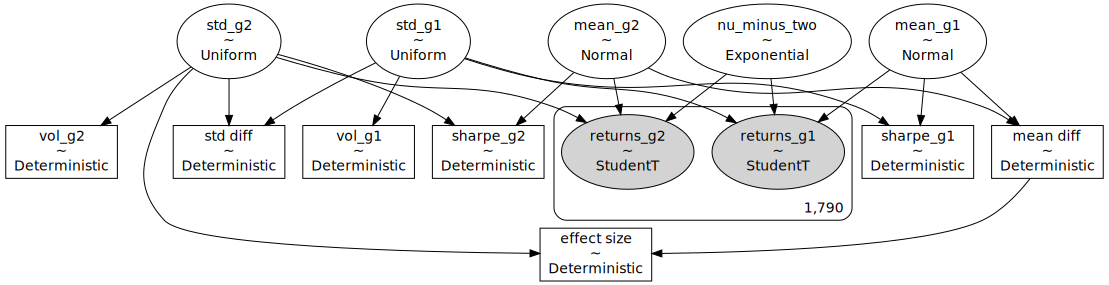

In [24]:
pm.model_to_graphviz(model=best)

In [25]:
# optional
# graph = pm.model_to_graphviz(model=best)
# graph.save('best.dot')

### HMC NUTS Sampling

In [26]:
with best:    
    trace = pm.sample(draws=10000, 
                      tune=2500, 
                      progressbar=True, 
                      cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [std_g2, mean_g2, std_g1, mean_g1, nu_minus_two]


Sampling 2 chains for 2_500 tune and 10_000 draw iterations (5_000 + 20_000 draws total) took 45 seconds.


In [27]:
pm.trace_to_dataframe(trace).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean_g1       20000 non-null  float64
 1   mean_g2       20000 non-null  float64
 2   nu_minus_two  20000 non-null  float64
 3   std_g1        20000 non-null  float64
 4   vol_g1        20000 non-null  float64
 5   sharpe_g1     20000 non-null  float64
 6   std_g2        20000 non-null  float64
 7   vol_g2        20000 non-null  float64
 8   sharpe_g2     20000 non-null  float64
 9   mean diff     20000 non-null  float64
 10  std diff      20000 non-null  float64
 11  effect size   20000 non-null  float64
dtypes: float64(12)
memory usage: 1.8 MB


### Evaluating the Trace

To compare the performance of two return series, we model each group’s Sharpe ratio separately and compute the effect size as the difference between the volatility-adjusted returns. Visualizing the traces reveals granular performance insights into the distributions of each metric as illustrated by the following chart.

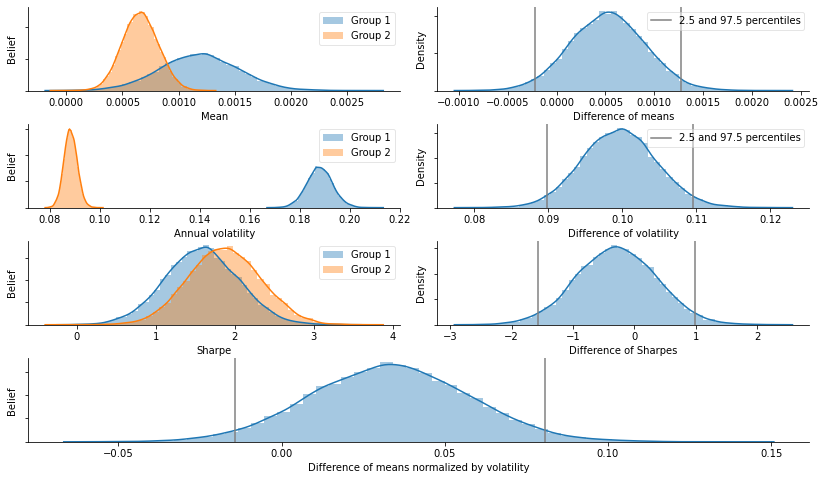

In [28]:
burn = 0
trace = trace[burn:]

fig = plt.figure(figsize=(14, 8), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, wspace=0.1, hspace=0.4)
axs = [plt.subplot(gs[i, j]) for i in [0, 1, 2] for j in [0, 1]]
axs.append(plt.subplot(gs[3, :]))

def distplot_w_perc(trace, ax):
    sns.distplot(trace, ax=ax)
    ax.axvline(stats.scoreatpercentile(trace, 2.5), color='0.5', label='2.5 and 97.5 percentiles')
    ax.axvline(stats.scoreatpercentile(trace, 97.5), color='0.5')

for i in [1, 2]:
    label = f'Group {i}'
    sns.distplot(trace[f'mean_g{i}'], ax=axs[0], label=label)
    sns.distplot(trace[f'vol_g{i}'], ax=axs[2], label=label)
    sns.distplot(trace[f'sharpe_g{i}'], ax=axs[4], label=label)

distplot_w_perc(trace['mean diff'], axs[1])
distplot_w_perc(trace['vol_g1'] - trace['vol_g2'], axs[3])
distplot_w_perc(trace['sharpe_g1'] - trace['sharpe_g2'], axs[5]) 

sns.distplot(trace['effect size'], ax=axs[6])
for p in [2.5, 97.5]:
    axs[6].axvline(stats.scoreatpercentile(trace['effect size'], p), color='0.5')

for i in range(5):
    axs[i].legend(loc=0, frameon=True, framealpha=0.5)

axs[0].set(xlabel='Mean', ylabel='Belief', yticklabels=[])
axs[1].set(xlabel='Difference of means', yticklabels=[])
axs[2].set(xlabel='Annual volatility', ylabel='Belief', yticklabels=[])
axs[3].set(xlabel='Difference of volatility', yticklabels=[])
axs[4].set(xlabel='Sharpe', ylabel='Belief', yticklabels=[])
axs[5].set(xlabel='Difference of Sharpes', yticklabels=[])
axs[6].set(xlabel='Difference of means normalized by volatility', ylabel='Belief', yticklabels=[])
sns.despine()
fig.tight_layout()

In [29]:
def plot_traces(traces, burnin=2000):
    ''' 
    Plot traces with overlaid means and values
    '''
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', 
                          xy=(mn, 0), 
                          xycoords='data', 
                          xytext=(5, 10), 
                          textcoords='offset points', 
                          rotation=90, 
                          va='bottom', 
                          fontsize='large', 
                          color='#AA0022')

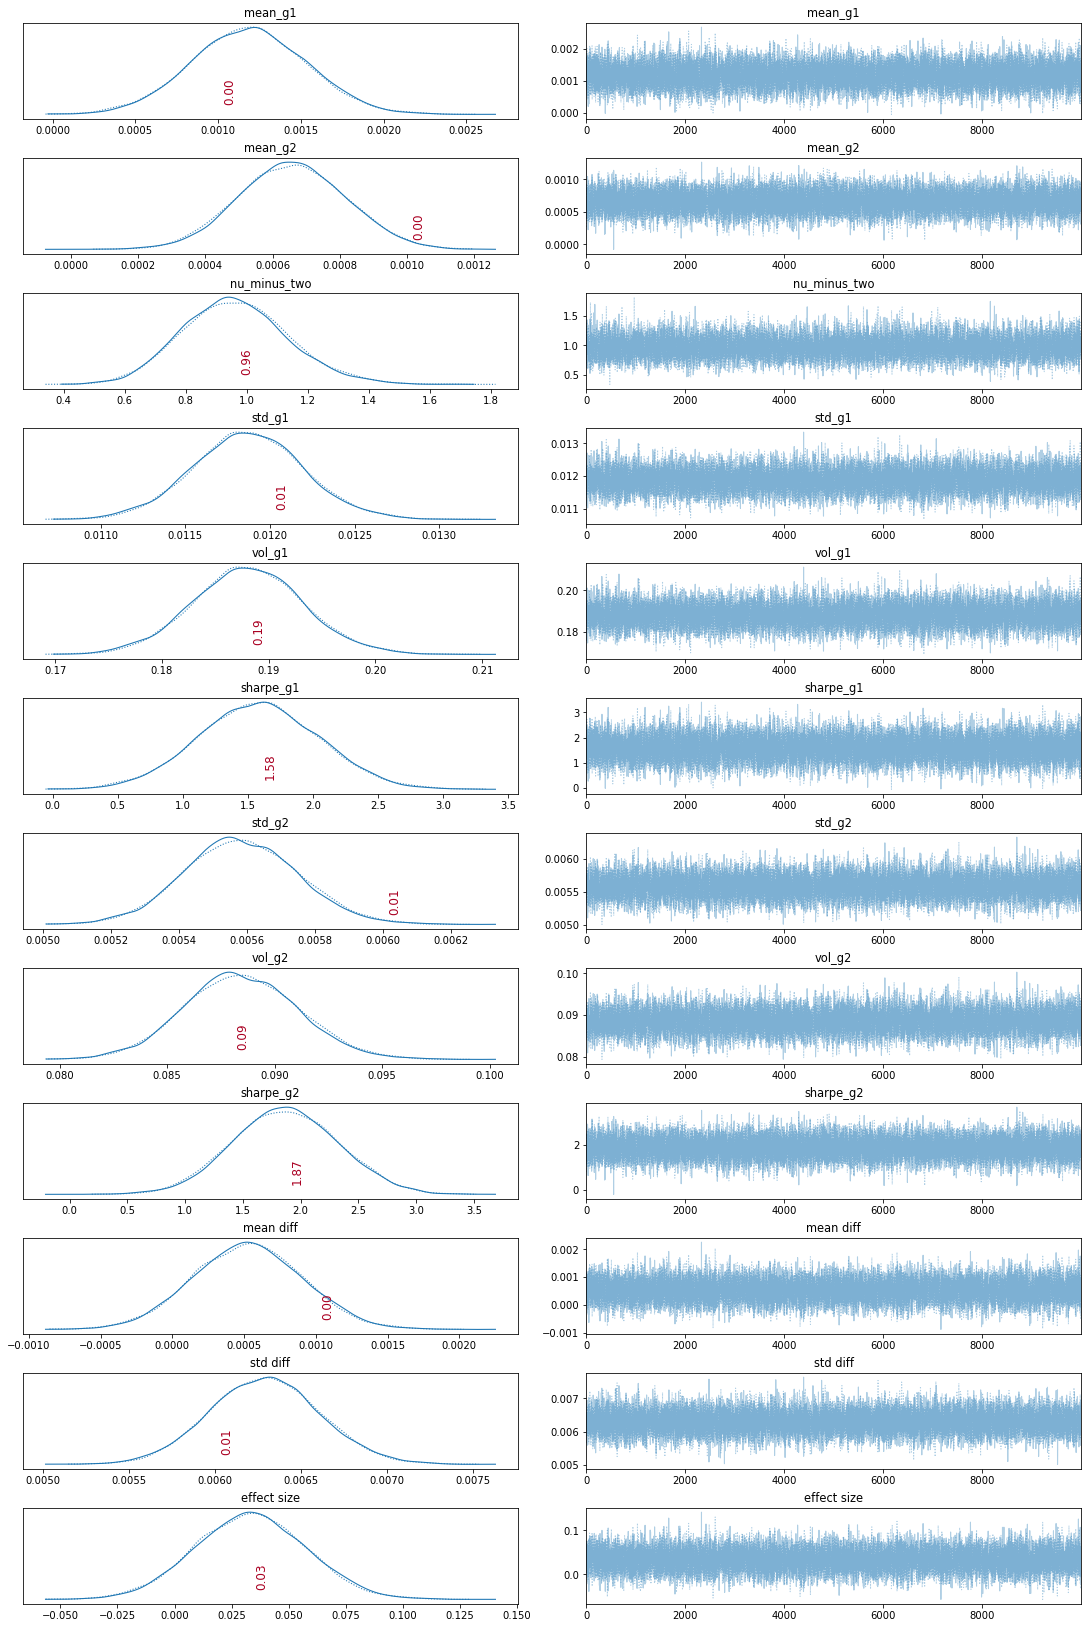

In [30]:
plot_traces(trace, burnin=0)